In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
import transformers
from transformers import AutoModelForTokenClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy
from IPython.display import clear_output
from huggingface_hub import notebook_login
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import seaborn as sns

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.container.auxiliary_functions import F_mean, F_cov
from src.model.container.trainer import ContainerTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
notebook_login()

In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
model_name = "few_shot_learning"
dataset_name = "sroie"

In [5]:
logging.basicConfig(filename='logs/few_shot_learning_cord.log', encoding='utf-8', level= logging.INFO)

## Importing source and support dataset

In [6]:
source_dataset = load_dataset(
    "nielsr/funsd",
    cache_dir = "/Data/pedro.silva/"
)
support_dataset = load_dataset(
    "darentang/sroie",
    cache_dir = "/Data/pedro.silva/"
)

In [7]:
model = AutoModel.from_pretrained(
    "microsoft/layoutlm-base-uncased",
    cache_dir = "/Data/pedro.silva/"
).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/layoutlm-base-uncased",
    cache_dir = "/Data/pedro.silva/"
)

In [8]:
source_dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [9]:
valid_labels ={
    0: 0,
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 3,
    6: 3,
    7: 4,
    8: 4
}

source_df = ImageLayoutDataset(
    source_dataset['train'],
    tokenizer,
    valid_labels_keymap= valid_labels
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:00<00:00, 160.12it/s]


In [10]:
input = source_df[0]

In [11]:
out = model(
    input_ids=input['input_ids'].reshape(1,-1), 
    bbox= input['bbox'].reshape([1, 512, 4]),
    attention_mask=input['attention_mask'].reshape(1,-1), 
    token_type_ids=input['token_type_ids'].reshape(1,-1),
)

In [12]:
out.last_hidden_state.shape

torch.Size([1, 512, 768])

In [13]:
input_dim = 768
output_dim = 64
hidden_size = 128

f_mean = F_mean(
    input_dim,
    output_dim
)

f_cov = F_cov(
    input_dim,
    output_dim
)

In [14]:
out.last_hidden_state[:,0, :].shape

torch.Size([1, 768])

In [15]:
params = list(f_mean.parameters()) + list(f_cov.parameters()) + list(model.parameters())
optimizer = torch.optim.Adam(
    params,
    lr = 1e-4
)

## Train on source set

In [16]:
checkpoint_f_mean = "/Data/pedro.silva/f_mean_funsd-b.pt"
checkpoint_f_cov = "/Data/pedro.silva/f_cov_funsd-b.pt"
checkpoint_llm = "peulsilva/container-source-funsd-checkpoint-b"

In [17]:
trainer = ContainerTrainer(
    model,
    f_mean,
    f_cov,
    optimizer,
    checkpoint_llm,
    checkpoint_f_mean,
    checkpoint_f_cov
)

In [22]:
trainer.train_on_source_set(
    source_df,
    save = True,
    num_batches=20
)

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

## Few shot learning on support domain - 2 shots

In [19]:
label_names = ['None', "Company", "Date", "Address", "Total"]

In [20]:
support_dataset['train'].features['ner_tags'].feature.names

['O',
 'B-COMPANY',
 'I-COMPANY',
 'B-DATE',
 'I-DATE',
 'B-ADDRESS',
 'I-ADDRESS',
 'B-TOTAL',
 'I-TOTAL']

In [21]:
n_shots = 2
valid_labels_funsd = {
    0: 0,
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3,
    7: 4,
    8: 4
}



support_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/626 [00:00<?, ?it/s]

100%|██████████| 626/626 [00:03<00:00, 185.93it/s]


In [22]:
val_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/626 [00:00<?, ?it/s]

100%|██████████| 626/626 [00:03<00:00, 187.04it/s]


In [45]:
history = trainer.train_on_support_set(
    support_df,
    val_df,
    n_shots=2
)

epoch 9
loss: 0.08546812832355499
running validation


100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


f1: 0.8611798094465842
[[18481   768     0  1192     0]
 [   59   586     0   159     0]
 [  429     7     2    41     0]
 [  187   262     0  2172     0]
 [  309     2     0     9     0]]


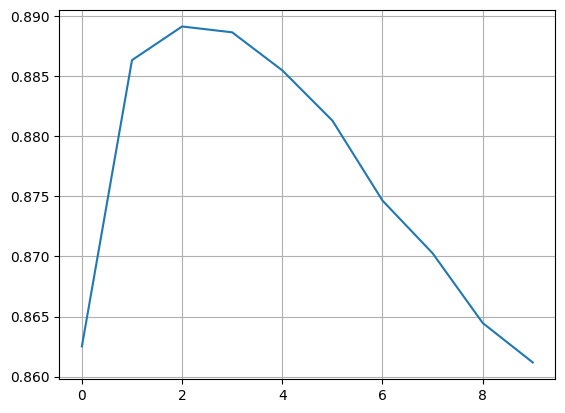

In [46]:
plt.plot(history)
plt.grid()

## Evaluation

In [47]:
test_df = ImageLayoutDataset(
    support_dataset['test'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:01<00:00, 185.26it/s]


In [48]:
y_true, y_pred = trainer.test(
    support_df,
    test_df,
    n_shots=2
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:12<00:00, 28.81it/s]


In [49]:
f1= f1_score(y_true, y_pred, average='micro')
conf_matrix = confusion_matrix(y_true, y_pred)

In [50]:
f1

0.8869476430880935

Text(0.5, 1.0, 'Performance - FUNSD - 2 shots')

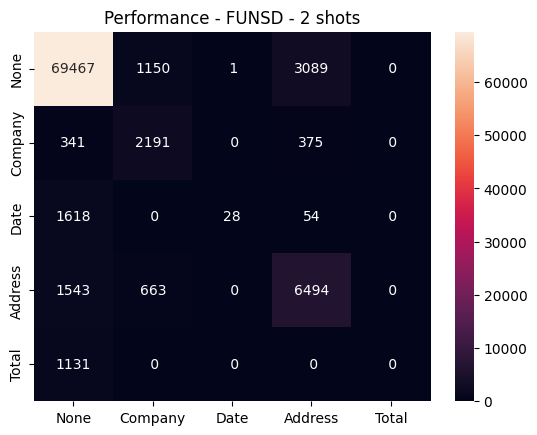

In [51]:
df = pd.DataFrame(
    conf_matrix,
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 2 shots")

## Few shot learning on support domain - 5 shots

In [28]:
history = trainer.train_on_support_set(
    support_df,
    val_df,
    n_shots=5
)

epoch 9
loss: 0.07460702955722809
running validation


100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


f1: 0.8508689812365176
[[18081   319    32  1808   194]
 [   68   512     0   220     0]
 [  271    12    93    26    75]
 [  305    17     0  2216     0]
 [  316     1     0     0     3]]


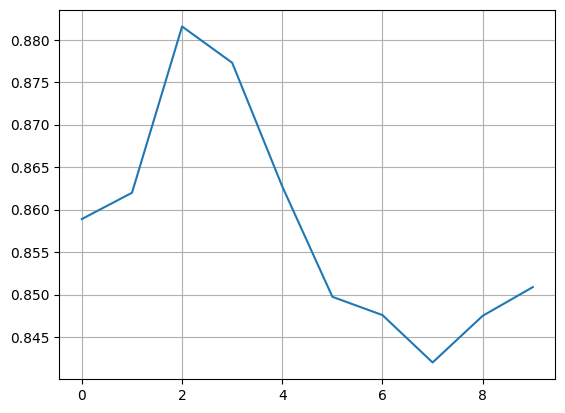

In [29]:
plt.plot(history)
plt.grid()

In [30]:
val_df[0]['labels'][:,0]

tensor([-100], device='cuda:0')

## Evaluation

In [31]:
test_df = ImageLayoutDataset(
    support_dataset['test'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:01<00:00, 186.50it/s]


In [37]:
y_true, y_pred = trainer.test(
    support_df,
    test_df,
    5
)

100%|██████████| 347/347 [00:11<00:00, 29.21it/s]


In [38]:
f1= f1_score(y_true, y_pred, average='micro')
conf_matrix = confusion_matrix(y_true, y_pred)

In [39]:
f1

0.8737761642747746

Text(0.5, 1.0, 'Performance - FUNSD - 5 shots')

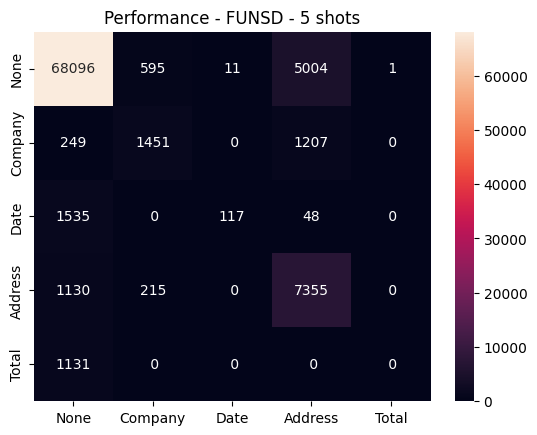

In [40]:
df = pd.DataFrame(
    conf_matrix,
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 5 shots")

## Few shot learning on support domain - 10 shots

In [23]:
history = trainer.train_on_support_set(
    support_df,
    val_df,
    n_shots=10
)

epoch 9
loss: 0.07336997240781784
running validation


100%|██████████| 100/100 [00:03<00:00, 28.77it/s]


f1: 0.8977378120085487
[[19297   500    15   859     7]
 [   50   690     0    46     0]
 [  338     0   111    27     1]
 [   77   296     0  2164     0]
 [  306    12     0     2     1]]


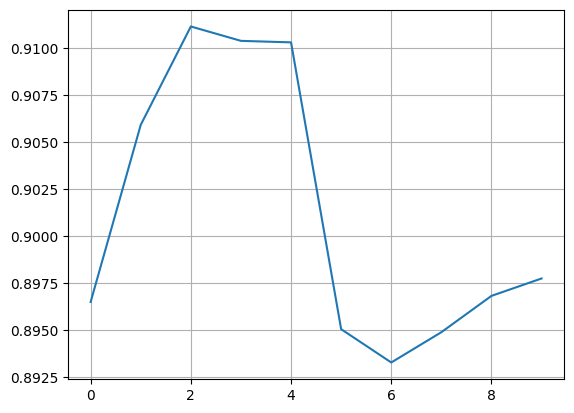

In [24]:
plt.plot(history)
plt.grid()

## Evaluation

In [25]:
test_df = ImageLayoutDataset(
    support_dataset['test'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:01<00:00, 189.29it/s]


In [26]:
y_true, y_pred = trainer.test(
    support_df,
    test_df,
    10
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:11<00:00, 29.17it/s]


In [27]:
f1= f1_score(y_true, y_pred, average='micro')
conf_matrix = confusion_matrix(y_true, y_pred)

In [28]:
f1

0.9102501559929661

Text(0.5, 1.0, 'Performance - FUNSD - 10 shots')

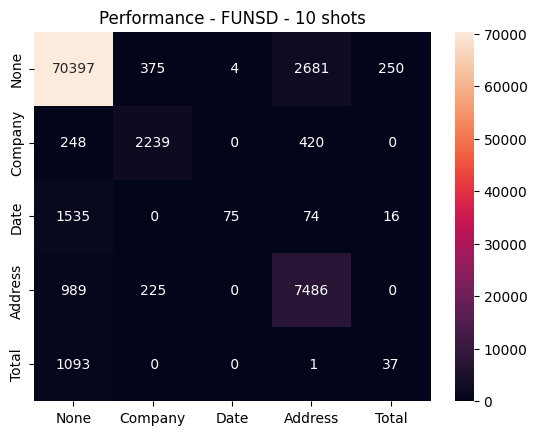

In [29]:
df = pd.DataFrame(
    conf_matrix,
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 10 shots")

## Results analysis - comparison with base model

In [30]:
base_model = AutoModel.from_pretrained(
    "microsoft/layoutlm-base-uncased",
    cache_dir = "/Data/pedro.silva/"
).to(device)

model = trainer.best_model

In [95]:
model.push_to_hub("peulsilva/sroie-container-10_shots")

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/peulsilva/sroie-container-10_shots/commit/a652d330d8792dd968913454b2e596a6208ed335', commit_message='Upload model', commit_description='', oid='a652d330d8792dd968913454b2e596a6208ed335', pr_url=None, pr_revision=None, pr_num=None)

In [56]:
trained_vectors = []
base_vectors = []
labels = []

with torch.no_grad():
    for i in tqdm(range(len(test_df))):
        input = test_df[i]
        mask = input['labels'] != -100

        labels.append(
            input['labels'][mask]\
                .cpu()\
                .detach()\
                .numpy()
        )

        out1 = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        trained_vectors.append(
            out1.last_hidden_state\
                [mask]\
                .cpu()\
                .detach()\
                .numpy()
        )

        out2 = base_model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        base_vectors.append(
            out2.last_hidden_state\
            [mask]\
            .cpu()\
            .detach()\
            .numpy()
        )

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:08<00:00, 41.63it/s]


In [68]:
concat_base_vectors = np.concatenate(base_vectors)
concat_trained_vectors = np.concatenate(trained_vectors)
concat_labels = np.concatenate(labels)

In [72]:
pca = PCA(n_components=2)
x1 = pca.fit_transform(concat_trained_vectors)
x2 = pca.fit_transform(concat_base_vectors)

In [76]:
df1 = pd.DataFrame(x1)
df1['labels'] = concat_labels

df2 = pd.DataFrame(x2)
df2['labels'] = concat_labels

In [84]:
grouped_features1 = df1.groupby('labels').apply(lambda x: x.iloc[:, :-1].values)
grouped_features2 = df2.groupby('labels').apply(lambda x: x.iloc[:, :-1].values)

In [85]:
label_names

['None', 'Company', 'Date', 'Address', 'Total']

In [90]:
grouped_features1[0]

array([[14.5737   , -3.3669028],
       [14.481929 , -3.231103 ],
       [13.729918 , -3.557385 ],
       ...,
       [-3.7542615, -1.5464085],
       [-3.7056146, -1.6295524],
       [-3.9205012, -1.3273598]], dtype=float32)

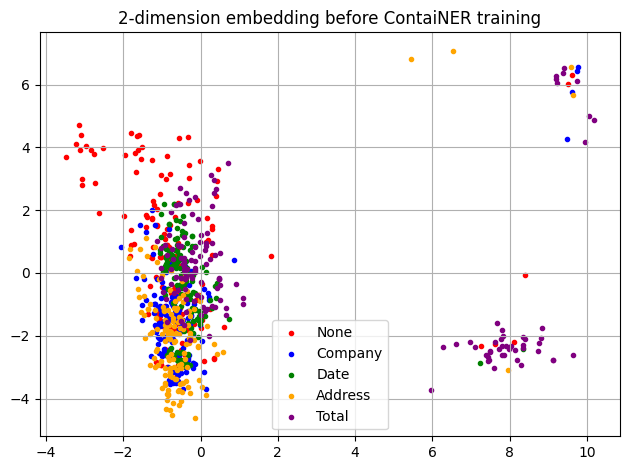

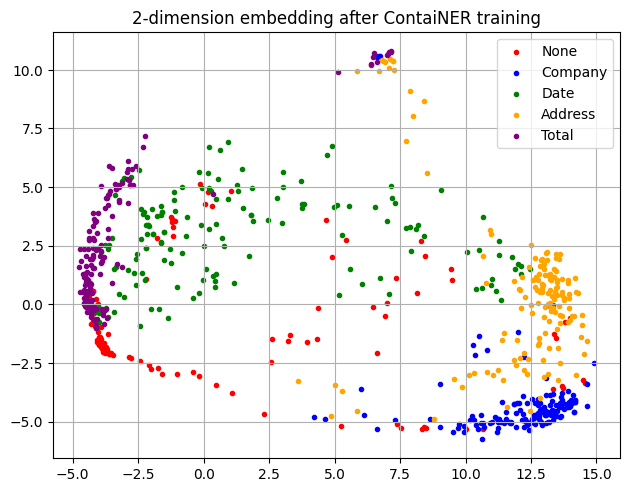

In [96]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
num_classes = len(label_names)
num_shots = 150

for c in range(num_classes):    
    
    plt.scatter(
        grouped_features2[c][0:num_shots,0], 
        grouped_features2[c][0:num_shots, 1],        
        marker = '.',
        c = colors[c],
        label = label_names[c]
    )

plt.legend()
plt.grid()
plt.title("2-dimension embedding before ContaiNER training")
plt.tight_layout()
plt.show()

for c in range(num_classes):    
    
    plt.scatter(
        grouped_features1[c][0:num_shots,0], 
        grouped_features1[c][0:num_shots, 1],        
        marker = '.',
        c = colors[c],
        label = label_names[c]
    )

plt.legend()
plt.grid()
plt.tight_layout()
plt.title("2-dimension embedding after ContaiNER training")
plt.show()
